A.S. Lundervold, 29.02.2024

# Introduction

This notebook steps through an example of text classification using fastai's ULMFiT and DistilBERT models via Hugging Face's Transformers library.

> Be sure to also work through [Chapter 10](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) of the fastai textbook and [Lesson 4](https://course.fast.ai/Lessons/lesson4.html) of the fastai course.

# Setup

In [1]:
%matplotlib inline
from pathlib import Path
import os, sys
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from fastcore.all import *

In [2]:
DATA = Path.home() /'data'/'dat255'
DATA

Path('/home/alex/data/dat255')

# Load data

We can find many datasets on the Hugging Face Hub:

In [3]:
from huggingface_hub import HfApi

In [4]:
api = HfApi()

Here's a list of all the available datasets. There are a lot!

In [7]:
len(list(api.list_datasets()))

113131

Here are the 20 most popular datasets:

In [8]:
[ds.id for ds in list(api.list_datasets(sort="downloads", direction=-1))][:20]

['argilla/databricks-dolly-15k-curated-en',
 'hails/mmlu_no_train',
 'cais/mmlu',
 'etechgrid/Prompts_for_Voice_cloning_and_TTS',
 'lukaemon/mmlu',
 'wiki_dpr',
 'wikitext',
 'glue',
 'lavita/medical-qa-shared-task-v1-toy',
 'etechgrid/prompts_for_TTM',
 'squad',
 'ceval/ceval-exam',
 'super_glue',
 'wikipedia',
 'imdb',
 'truthful_qa',
 'ag_news',
 'samsum',
 'winogrande',
 'cifar10']

In this notebook, we'll use the `emotion` dataset sourced from [CARER: Contextualized Affect Representations for Emotion Recognition](https://aclanthology.org/D18-1404) (Saravia et al., EMNLP 2018). This dataset contains 16,000 tweets, each labeled with one of 6 emotions: anger, fear, joy, love, sadness, and surprise.

> **Your turn!** Feel free to repeat the story with a different dataset!

In [5]:
from datasets import load_dataset
emotion = load_dataset("emotion", cache_dir=DATA)

/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [10]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Here are the first few tweets and their corresponding emotions:

In [11]:
emotion['train'][0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

For convenience, we'll store the data in a Pandas DataFrame.

In [12]:
# For convenience, we'll store the data in a Pandas DataFrame, adding a "usage" column indicating train, validation, test
df = pd.concat([pd.DataFrame(emotion['train']), pd.DataFrame(emotion['validation']), pd.DataFrame(emotion['test'])])

# Add named labels
idx_to_emotion = dict(enumerate(emotion['train'].features['label'].names))
df['named_label'] = df['label'].map(idx_to_emotion)

# Add "usage" column
df['usage'] = np.array(['train']*len(emotion['train']) + ['valid']*len(emotion['validation']) + ['test']*len(emotion['test']))

In [13]:
pd.set_option('display.max_colwidth', None)

In [14]:
df.head()

,text,label,named_label,usage
0,i didnt feel humiliated,0,sadness,train
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0,sadness,train
2,im grabbing a minute to post i feel greedy wrong,3,anger,train
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2,love,train
4,i am feeling grouchy,3,anger,train


In [15]:
df.usage.value_counts()

usage
train    16000
valid     2000
test      2000
Name: count, dtype: int64

The task is to classify each tweet into one of the six emotions.


# Ulmfit using fastai

Remember from fastai that the ULMFiT approach consists of three steps:

0. **LM pretraining**: Train a language model on a large corpus of text.
1. **LM fine-tuning**: Fine-tune the language model on the target dataset.
2. **Classifier training**: Fine-tune a classifier built from the LM on the target dataset.

In our case, we'll skip the LM pretraining and use a model that's been trained on text from Wikipedia (the [Wikitext-103 data set](https://developer.ibm.com/exchanges/data/all/wikitext-103/)). 

Here's an illustration of the approach taken from fastai: 

<img width=80% src="https://docs.fast.ai/images/ulmfit.png"><br><small>Figure from https://docs.fast.ai/tutorial.text.html</small>

In [16]:
from fastai.text.all import *

For convenience when using fastai, we add indicator variables for the training, testing and validation sets. We also separate the training and validation dataframe from the one containing test data (which we'll use for the final evaluation).

In [17]:
df.loc[:, 'is_test'] = df.usage=='test'

In [18]:
df_train = df[(df.usage=='train') | (df.usage=='valid')].copy()
df_test = df[df.usage=='test']

In [19]:
df_train.loc[:, 'is_valid'] = df_train.usage=='valid'

In [20]:
df.is_test.value_counts()

is_test
False    18000
True      2000
Name: count, dtype: int64

In [21]:
df_train.is_valid.value_counts()

is_valid
False    16000
True      2000
Name: count, dtype: int64

## Step 1: Fine-tune the language model

In [22]:
data_lm = TextDataLoaders.from_df(df_train, text_col='text', label_col="named_label", 
                                  is_lm=True, bs=64, valid_col="is_valid")

In [23]:
data_lm.show_batch(max_n=3)

,text,text_
0,xxbos a certain friend tried to push me off a seat in a very violent way for no apparent reason it may be that he was excited about something xxbos i feel numb xxunk nd xxbos i xxunk my teeth shook my head and spent the next minutes feeling irritated xxbos i feel pathetic xxunk in stiff and xxunk xxunk my mind xxunk and dreams of beyond xxbos i get the feeling,a certain friend tried to push me off a seat in a very violent way for no apparent reason it may be that he was excited about something xxbos i feel numb xxunk nd xxbos i xxunk my teeth shook my head and spent the next minutes feeling irritated xxbos i feel pathetic xxunk in stiff and xxunk xxunk my mind xxunk and dreams of beyond xxbos i get the feeling that
1,making xxunk xxbos i bring these to mind and feel the joyful laughter well up within my heart it becomes hard to remain xxunk down by the heavier negative feelings xxbos i feel like i m getting less intelligent more and more each day xxbos i want to be xxunk and until i find the person who makes me feel that way than i think i d rather stay single because if,xxunk xxbos i bring these to mind and feel the joyful laughter well up within my heart it becomes hard to remain xxunk down by the heavier negative feelings xxbos i feel like i m getting less intelligent more and more each day xxbos i want to be xxunk and until i find the person who makes me feel that way than i think i d rather stay single because if i
2,home xxunk xxbos i m feeling that joy every day with some of the most gorgeous people i ve ever met and hope this thanksgiving you felt the same xxbos i have gone to xxunk and worked with the children and on the xxunk i feel very joyful to be able to be working for others xxbos i often feel overwhelmed with all of the office and administration work required of the,xxunk xxbos i m feeling that joy every day with some of the most gorgeous people i ve ever met and hope this thanksgiving you felt the same xxbos i have gone to xxunk and worked with the children and on the xxunk i feel very joyful to be able to be working for others xxbos i often feel overwhelmed with all of the office and administration work required of the teacher


In [24]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True,
                               metrics=[accuracy, Perplexity()],
                               model_dir='.').to_fp16()

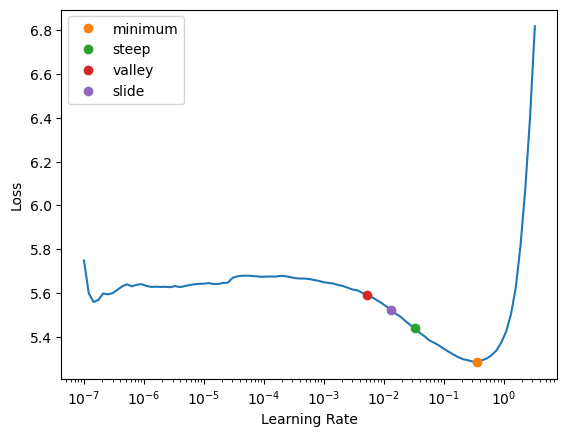

In [25]:
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [26]:
learn.fine_tune(3, lr.slide)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.734609,4.101740,0.263740,60.445393,00:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.205019,3.994756,0.280614,54.312588,00:13
1,4.072923,3.936640,0.288048,51.246124,00:13
2,3.928137,3.913315,0.292736,50.064655,00:13


We save the encoder part of the model, which we'll use in the next step.

In [27]:
learn.save_encoder('emotions_finetuned_lm_encoder')

### Test the language model

It's fun to test the language model by having it guess the next given number of words on a starting text:

In [28]:
from pprint import pprint as pp

In [29]:
def make_text(seed_text, nb_words):
    """
    Use the trained language model to produce text. 
    Input:
        seed_text: some text to get the model started
        nb_words: number of words to produce
    """
    pred = learn.predict(seed_text, nb_words, temperature=0.75)
    pp(pred)

In [30]:
make_text("I'm not feeling too good as my", 40)

('I xxunk not feeling too good as my husband was feeling a little bit nervous '
 'i feel like i m so stubborn i wanted to get a few little more up into it on '
 'the back of my heart when i feel pathetic nothing less than')


This seems to produce text that resembles the input text, but it's not very coherent. This is because the model is not designed to generate text, but to predict the next word in a sequence of words.

However, this is not the task we're interested in. 

> **Your turn!** You may want to train the LM on _all_ the data, including the validation and test data. 

## Step 2: Train the classifier

In [31]:
db = DataBlock(blocks=(TextBlock.from_df(text_cols='text', vocab=data_lm.vocab), CategoryBlock), 
                  get_x = ColReader(cols='text'), 
                  get_y = ColReader(cols='named_label'),
                  splitter = ColSplitter(col='is_test'))

dls = db.dataloaders(df, bs=16)

In [32]:
dls.show_batch()

,text,category
0,xxbos i feel in my bones like nobody cares if i m here nobody cares if i m gone here i am again saying i m feeling so lonely people either say its ok to be alone or just go home it xxunk me and i do nt know why it does nt mean i do nt try i try and try but people just treat me like i m a xxunk,sadness
1,xxbos i can remember when xxunk was a couple of months old looking at her sweet innocent face and just xxunk thinking about her going to school the thought that someone would hurt her feelings be unkind to her be unfair to her the thought that a teacher might be mean to her or not love her,anger
2,xxbos i feel neglectful and while at her reception i xxunk her arm as i walked by and she pulled me back and said where are you going you re way more xxunk than those people but i was stoned and full of champagne and could only tell her she was beautiful and that he seemed nice,sadness
3,xxbos i love the feeling of aching oh what are those xxunk things called on the front sides of my calves muscles and i love the fantasy that some day soon i will be xxunk in sports xxunk as the xxunk model of the year maybe they will make a special issue for the baby xxunk,sadness
4,xxbos i feel hateful to have given up my friendship with that woman and a couple of others for the same reasons to admit defeat and let my husband make me feel so insecure that i feel the need to avoid her cut her out of my life so that my xxunk is not challenged,anger
5,xxbos i respect his privacy so i wo nt xxunk details of our chat but it got me thinking about the notion of home coz i was feeling a little homesick in the morning and here i was with a total stranger a few thousand miles from singapore but i actually felt at home,sadness
6,xxbos i get bored i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything can happen in this world for an ordinary girl a class profile link href http xxrep 3 w,sadness
7,xxbos i was out the xxunk door feeling strange because at the last stage the entire thing seemed to slip out of my hands like a xxunk fish and also hopeful that i know what to do and if i can look at it positively it means just one more trip to xxunk,fear
8,xxbos i feel incredibly idiotic but i was also embarrassed because it had nt been their fault at all and i had yelled at one of the workers on the phone out of frustration about needing to call them a million times sending so many emails and still the problem was not solved,sadness


In [46]:
learn_clf = text_classifier_learner(dls, AWD_LSTM, pretrained=True, 
                                    metrics=[accuracy, 
                                             F1Score(average='weighted')
                                             ], 
                                    model_dir='.').to_fp16()

In [47]:
learn_clf = learn_clf.load_encoder('emotions_finetuned_lm_encoder')

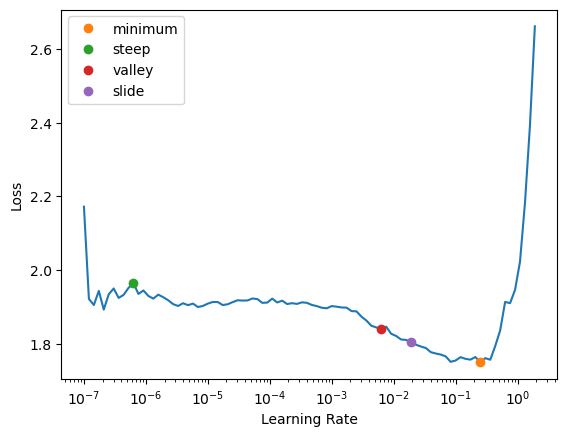

In [35]:
lr = learn_clf.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [48]:
learn_clf.fine_tune(7, base_lr=lr.valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.367607,1.221763,0.555500,0.486804,00:15


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.747841,0.532977,0.801000,0.793447,00:28
1,0.429285,0.247748,0.907500,0.906576,00:26
2,0.276349,0.167446,0.926500,0.924589,00:28
3,0.211146,0.148055,0.928000,0.925884,00:26
4,0.198333,0.124473,0.927000,0.925741,00:28
5,0.151707,0.129316,0.926500,0.926323,00:26
6,0.141577,0.131838,0.928500,0.929936,00:29


### Evaluating the model

In [49]:
learn_clf.show_results()

,text,category,category_
0,xxbos i feel i am appreciative i take care of the baby i try to keep the apt clean as much as possible and i try not to call him a million times to find out when hell be home it xxunk from day to day as he is sort of self xxunk so its hard to plan things around his schedule,joy,joy
1,xxbos i feel inside this life is like a game sometimes then you came around me the walls just xxunk nothing to surround me keep me from my fears i m unprotected see how i ve opened up you ve made me trust coz i ve never felt like this before i m naked around you does it show,sadness,sadness
2,xxbos i do nt have any photos with me because i was too excited and happy about my xxunk which i did great btw at least i feel xxunk i did since i felt confident and did nt xxunk in front the panel of xxunk we had and xxunk bf was around after doors opened for the public,joy,joy
3,xxbos i have the joy of allowing kids to feel like the valued xxunk that they are and to just have a xxunk being a kid alongside with them but can i just say its an incredibly xxunk experience to have influence into a xxunk life and to know that what you do and say is being xxunk,joy,joy
4,xxbos i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything could happen in this world for an ordinary girl like you like me for an ordinary girl like you like me how are you,sadness,sadness
5,xxbos i have an ed i will tell you that i know i shouldn t feel shamed of eating a protein bar for breakfast and the fact that i ate one isn t what makes me xxunk it s the fact i didn t make it is what made me hang my head and tuck xxunk,sadness,sadness
6,xxbos i feel fake because i think if you really want to have a good conversation and make good contact you have to appear especially self confident and even risk talking to some people which are no good to talk to at all until you meet one person which you have a good connection to,sadness,sadness
7,xxbos i ca nt help but think if i d just shut up if i d just not made a big deal of what was essentially two adults meeting at the same table for a hot xxunk then perhaps i would nt have spent the xxunk of the weekend feeling like a stupid shit,sadness,sadness
8,xxbos i got into the house feeling fairly calm the xxunk is xxunk his way in and out of xxunk doing touch ups my dad is telling a story my mom is running in and out of the house i manage to go through my list before the xxunk start xxunk for the dress,joy,joy


In [50]:
interp = ClassificationInterpretation.from_learner(learn_clf)

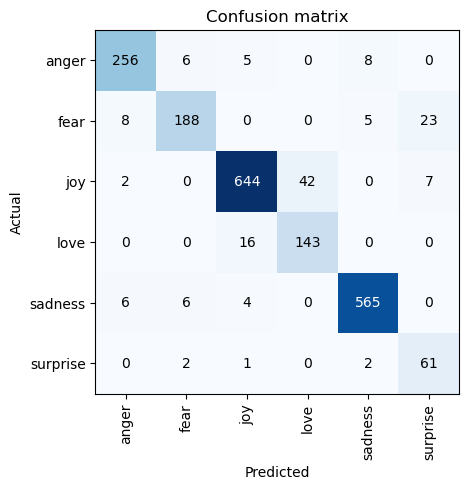

In [51]:
interp.plot_confusion_matrix()

In [52]:
interp.most_confused(min_val=5)

[('joy', 'love', 42),
 ('fear', 'surprise', 23),
 ('love', 'joy', 16),
 ('anger', 'sadness', 8),
 ('fear', 'anger', 8),
 ('joy', 'surprise', 7),
 ('anger', 'fear', 6),
 ('sadness', 'anger', 6),
 ('sadness', 'fear', 6),
 ('anger', 'joy', 5),
 ('fear', 'sadness', 5)]

In [53]:
interp.print_classification_report()

              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       275
        fear       0.93      0.84      0.88       224
         joy       0.96      0.93      0.94       695
        love       0.77      0.90      0.83       159
     sadness       0.97      0.97      0.97       581
    surprise       0.67      0.92      0.78        66

    accuracy                           0.93      2000
   macro avg       0.88      0.92      0.89      2000
weighted avg       0.93      0.93      0.93      2000



In [54]:
interp.plot_top_losses(7)

,input,target,predicted,probability,loss
0,xxbos i don t always feel like i have amazing style and most days i choose comfort over anything else but there is one thing that i feel makes all the difference in how i feel about myself and that is makeup,joy,surprise,0.9484491944313049,5.4573750495910645
1,xxbos i ve been feeling from my adoring fans that would be xxunk whole like of you who are my friends here i felt brave and excited and xxunk forth with guitar in hand to a local open xxunk night,love,joy,0.9944235682487488,4.547856330871582
2,xxbos i feel like i am in xxunk kissing those sweet lips make me feel like i xxunk into a magical world of love,joy,love,0.9579179286956787,3.6079494953155518
3,xxbos whenever i put myself in others shoes and try to make the person happy,anger,joy,0.9144247174263,3.314784288406372
4,xxbos i feel unprotected a class post count link href http xxunk in process,sadness,fear,0.9715642333030701,3.285337209701538
5,xxbos when we xxunk xxunk in our flat and got stuck in a chair,anger,fear,0.9483202695846558,3.2781283855438232
6,xxbos i feel much more energized than on a gloomy rainy autumn day,sadness,joy,0.9893108606338501,3.1855709552764893


In [55]:
learn_clf.save('emotion_classifier_ulmfit')

Path('emotion_classifier_ulmfit.pth')

# Using Transformers

Now, let's construct a classifier based on a Transformers model. We'll use Tranformer library from Hugging Face and the DistilBERT model.

> **Note:** You can combine the Transformers library with fastai as shown here: https://docs.fast.ai/tutorial.transformers.html. Below, we'll use the Transformer library directly.

## Preprocess data and set up model

In [6]:
import torch

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

num_labels = 6
model_ckpt = "distilbert-base-uncased"


model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(torch.device("cuda")))

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [9]:
emotion_tokenized = emotion.map(tokenize, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Train model

In [10]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [19]:
from transformers import Trainer, TrainingArguments

batch_size = 64

training_args = TrainingArguments(output_dir=".",
                                  num_train_epochs=6,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=100,
                                  log_level="error")
     

In [20]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_tokenized["train"],
                  eval_dataset=emotion_tokenized["validation"],
                  tokenizer=tokenizer)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.902373,0.673000,0.580570
2,1.130200,0.374782,0.894000,0.889606
3,1.130200,0.230436,0.924500,0.924430
4,0.335200,0.191376,0.928500,0.928332
5,0.181400,0.181026,0.935000,0.935041
6,0.181400,0.178362,0.933500,0.933948


/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: W

TrainOutput(global_step=378, training_loss=0.4668114197947992, metrics={'train_runtime': 78.6571, 'train_samples_per_second': 1220.487, 'train_steps_per_second': 4.806, 'total_flos': 2161028585088000.0, 'train_loss': 0.4668114197947992, 'epoch': 6.0})

## Evaluating the model

In [21]:
test_preds = trainer.predict(emotion_tokenized["test"])

/home/alex/anaconda3/envs/fastai/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [22]:
test_preds.metrics

{'test_loss': 0.18559770286083221,
 'test_accuracy': 0.931,
 'test_f1': 0.9315913228279017,
 'test_runtime': 0.67,
 'test_samples_per_second': 2985.086,
 'test_steps_per_second': 11.94}

> Alternative: Using LMs as feature extractors and training models on top of them

> **Your turn!** Try using the Transformer library via the fastai api as described here: https://docs.fast.ai/tutorial.transformers.html